In [1]:
import sys
sys.path.append("../data_analysis_and_preparation")
from prepare_human_feedback import get_data_from_excel

In [34]:
luca_df = get_data_from_excel("human_eval/final_evaluation_form_LB.xlsx", "human_eval/final_evaluation_model_key.xlsx")
luca_df

/home/niko/anaconda3/lib/python3.11/site-packages/openpyxl/reader/excel.py:228: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


,letter_id,n_footnote,model,text_footnote,style,usefullness,correctness,fact_check,commentary
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Recherche nötig,Enthält Fehlinformationen,None
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...","Der Text ist verständlich, aber stilistisch un...",Die Fussnote ist irrelevant,Keine Einschätzung möglich,None,None
2,11755,104,text_footnote,"Vgl. 1Kor 7, 25.",Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Recherche nötig,Keine Fehlinformationen,None
3,11755,104,llama-8B,"4, 1.",Der Text ist unverständlich,None,None,None,None
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.","Der Text ist verständlich, aber stilistisch un...",Die Fussnote ist relevant,Enthält Fehlinformationen,None,Die erste Fussnote enthält insofern Fehlinform...
...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Enthält Fehlinformationen,None,None
156,11537,20,llama-8B,Rodolphus Ryff.,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Enthält Fehlinformationen,None,None
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...","Der Text ist verständlich, aber stilistisch un...",Die Fussnote ist relevant,Keine Einschätzung möglich,None,None
158,11537,20,text_footnote,Landgräfin Christine von Hessen.,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Keine Einschätzung möglich,None,None


In [35]:
def transform_df(df):

    if "usefullness" in df.columns:  #typo...
        df.rename(columns={"usefullness":"usefulness"}, inplace=True)

    # include the correctness in the fact-checking
    df.loc[df["correctness"]!= "Recherche nötig", "fact_check"] = df.loc[df["correctness"]!= "Recherche nötig", "correctness"]
    print(df.iloc[1])
    for i, row in df.iterrows():
        df.loc[i,] = translate_row(row)
    
    return df

def translate_row(row):
    translator = {
        "style": {
            "Der Text ist unverständlich": "incomprehensible",
            "Der Text ist verständlich, aber stilistisch unpassend": "inadequate",
            "Der Text ist einer wissenschaftlichen Edition angemessen": "adequate"

        },
        "usefulness": {
            "Die Fussnote ist irrelevant ": "irrelevant",
            "Die Fussnote ist teilweise relevant": "partially relevant",
            "Die Fussnote ist relevant": "relevant",
        },
        "correctness":{
            "Enthält Fehlinformationen": "incorrect",
            "Keine Fehlinformationen": "correct",
            "Keine Einschätzung möglich": "subjective",
            "Recherche nötig": "research required"
        }
    }
    if row.style:
        row.style = translator["style"][row.style]
    if row.usefulness:
        row.usefulness = translator["usefulness"][row.usefulness]
    if row.fact_check:
        row.fact_check = translator["correctness"][row.fact_check]
    if row.correctness:
        row.correctness = translator["correctness"][row.correctness]
    
    # write "Human" instead of text_footnote
    if row.model == "text_footnote":
        row.model = "Human"
    
    return row

transform_df(luca_df)
    

letter_id                                                    11755
n_footnote                                                     104
model                                                       gpt-4o
text_footnote    Der Ausdruck "ad Kalendas Graecas" stammt aus ...
style            Der Text ist verständlich, aber stilistisch un...
usefulness                            Die Fussnote ist irrelevant 
correctness                             Keine Einschätzung möglich
fact_check                              Keine Einschätzung möglich
commentary                                                    None
Name: 1, dtype: object


,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,research required,incorrect,None
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,irrelevant,subjective,subjective,None
2,11755,104,Human,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None
3,11755,104,llama-8B,"4, 1.",incomprehensible,None,None,None,None
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",inadequate,relevant,incorrect,incorrect,Die erste Fussnote enthält insofern Fehlinform...
...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,incorrect,incorrect,None
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,relevant,subjective,subjective,None
158,11537,20,Human,Landgräfin Christine von Hessen.,adequate,relevant,subjective,subjective,None


In [48]:
import matplotlib.pyplot as plt
def plot_human_eval(df):
    # Assuming luca_df is already defined
    # Group and calculate counts for each category
    categories = ['style', 'usefulness', "correctness", 'fact_check']
    # grouped_data = {cat: df.groupby(['model', cat]).size().unstack(fill_value=0) for cat in categories}
    grouped_data = {
    cat: luca_df.groupby(['model', cat]).size().unstack(fill_value=0).apply(lambda x: (x / x.sum()) * 100, axis=1)
    for cat in categories
    }

    category_colors = {
    'adequate': 'blue',
    'inadequate': 'green',
    'incomprehensible': 'red',
    'irrelevant': 'blue',  # Example mappings,
    "partially relevant": "green",
    "relevant": "red",
    "correct": "blue",
    "incorrect": "green",
    "subjective": "red",
    "research required": "orange"
    }
    

    # Set up a 2x2 grid for the subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten the 2x2 array to easily iterate

    # Colors for the bar plots
    colors = ['blue', 'green', 'red', 'orange']

    # Loop through each category and corresponding axis
    for idx, (cat, ax) in enumerate(zip(categories, axes)):
        grouped_data[cat].plot(
            kind='bar',
            ax=ax,
            color=category_colors,
            edgecolor='black',
            legend=True
        )
            # Rotate tick descriptions horizontally
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.set_title(cat.replace("_", " ").title())
        ax.set_xlabel('')
        ax.set_ylabel('Percentage')
        ax.grid(True, axis="y", linestyle='--', alpha=0.6)
        # Create a custom legend for each subplot
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend(
            handles=legend_handles,
            labels=legend_labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.15),  # Adjust position below each chart
            ncol=len(legend_handles),  # Arrange in a single row
        )


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25) 
    return fig



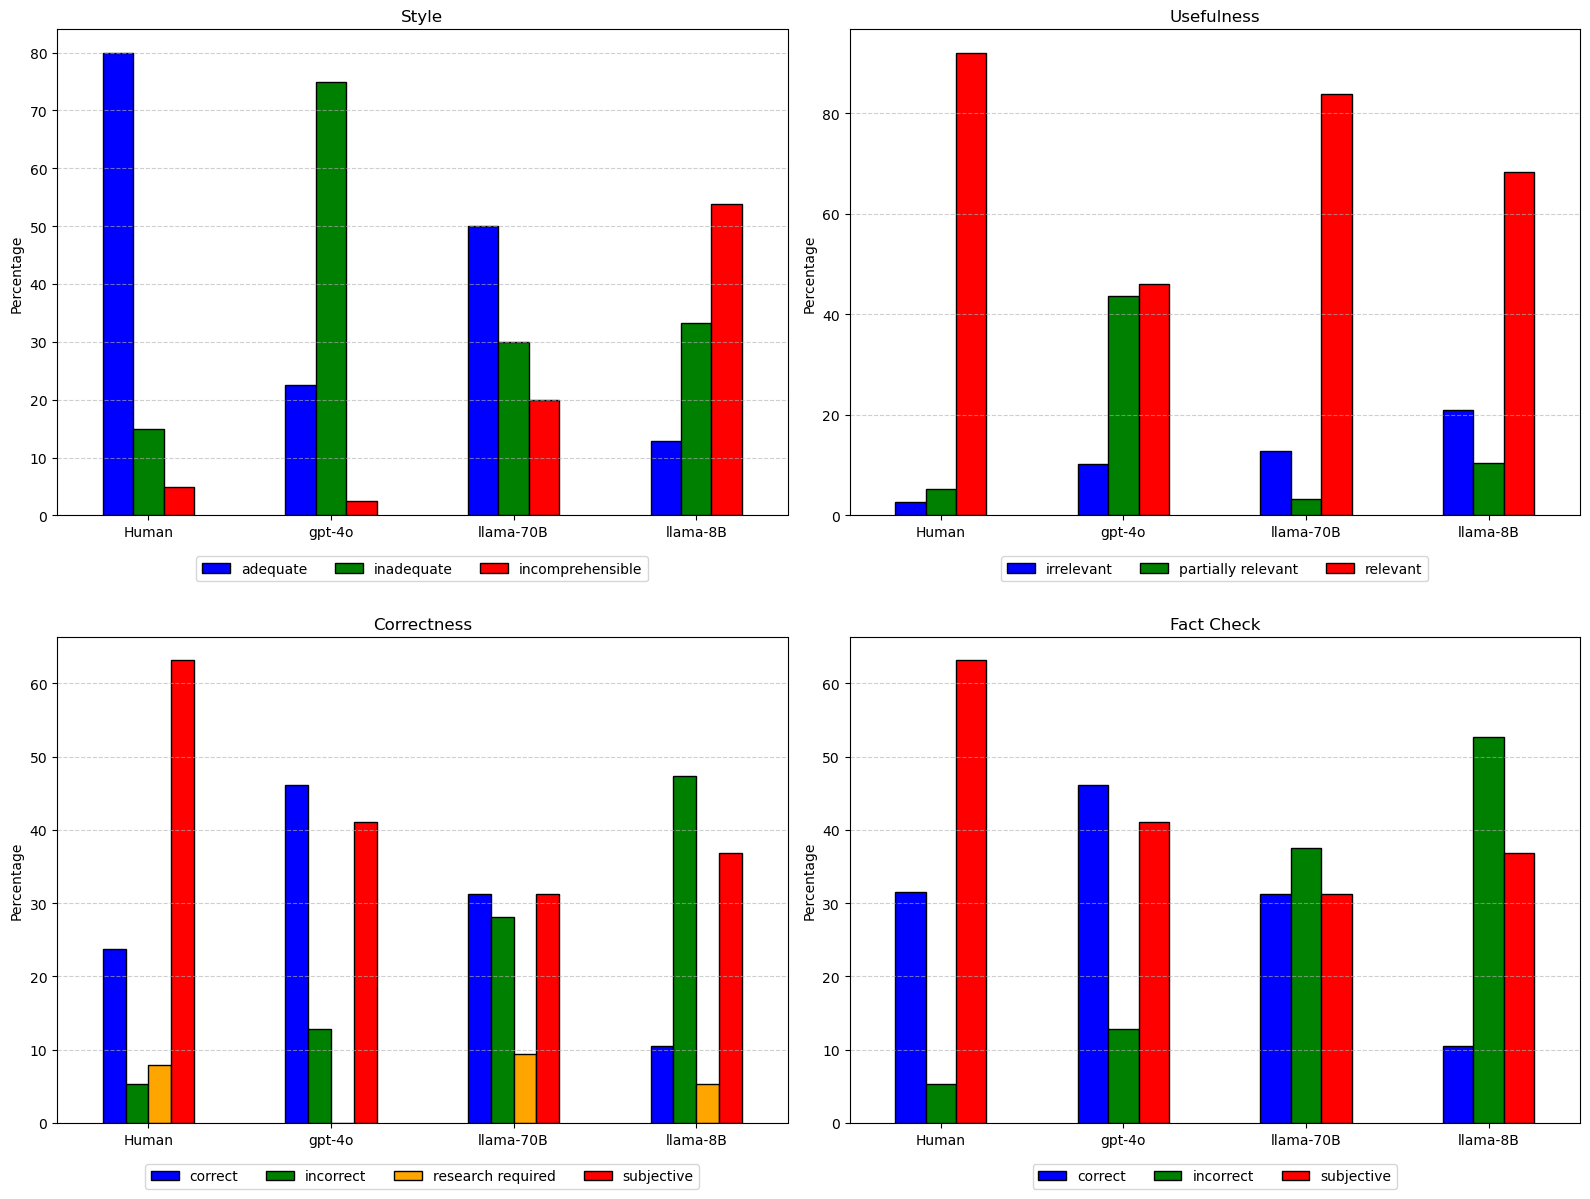

In [ ]:
import os
fig = plot_human_eval(luca_df)
if False:
    plot_folder = os.path.abspath(r"/mnt/c/Users/nik_b/Documents/UZH/CL/Master_thesis_text/master-thesis/images/plots")
    # plot_folder = "../plots"
    plot_name = "humanEval-LB.pdf"
    plt.savefig(os.path.join(plot_folder, plot_name), dpi=300, bbox_inches='tight',format='pdf')

In [ ]:
def human_footnote_ranking(df):
    # For each footnote and category calculate a ranking

    {}

,letter_id,n_footnote,model,text_footnote,style,usefullness,correctness,fact_check,commentary
0,11755,104,llama-70B,Paulus hab von der jungfrawschafft (on zweifel...,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Recherche nötig,Enthält Fehlinformationen,None
1,11755,104,gpt-4o,None,"Der Text ist verständlich, aber stilistisch un...",Die Fussnote ist irrelevant,Keine Einschätzung möglich,None,None
2,11755,104,text_footnote,None,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Recherche nötig,Keine Fehlinformationen,None
3,11755,104,llama-8B,None,Der Text ist unverständlich,None,None,None,None
4,10052,38,llama-70B,"Es ist ye gwüß, daß gott den eelichen stand ha...","Der Text ist verständlich, aber stilistisch un...",Die Fussnote ist relevant,Enthält Fehlinformationen,None,Die erste Fussnote enthält insofern Fehlinform...
...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,None,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Enthält Fehlinformationen,None,None
156,11537,20,llama-8B,"Alteram__20 vidi gravidam, et mox quoque parit...",Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Enthält Fehlinformationen,None,None
157,11537,20,gpt-4o,None,"Der Text ist verständlich, aber stilistisch un...",Die Fussnote ist relevant,Keine Einschätzung möglich,None,None
158,11537,20,text_footnote,None,Der Text ist einer wissenschaftlichen Edition ...,Die Fussnote ist relevant,Keine Einschätzung möglich,None,None


In [4]:
transform_df(luca_df)

letter_id                                                    11755
n_footnote                                                     104
model                                                       gpt-4o
text_footnote    Der Ausdruck "ad Kalendas Graecas" stammt aus ...
style            Der Text ist verständlich, aber stilistisch un...
usefullness                           Die Fussnote ist irrelevant 
correctness                             Keine Einschätzung möglich
fact_check                              Keine Einschätzung möglich
commentary                                                    None
Name: 1, dtype: object


,letter_id,n_footnote,model,text_footnote,style,usefullness,correctness,fact_check,commentary
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,research required,incorrect,None
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,irrelevant,subjective,subjective,None
2,11755,104,text_footnote,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None
3,11755,104,llama-8B,"4, 1.",incomprehensible,None,None,None,None
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",inadequate,relevant,incorrect,incorrect,Die erste Fussnote enthält insofern Fehlinform...
...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,incorrect,incorrect,None
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,relevant,subjective,subjective,None
158,11537,20,text_footnote,Landgräfin Christine von Hessen.,adequate,relevant,subjective,subjective,None


<Axes: xlabel='model'>

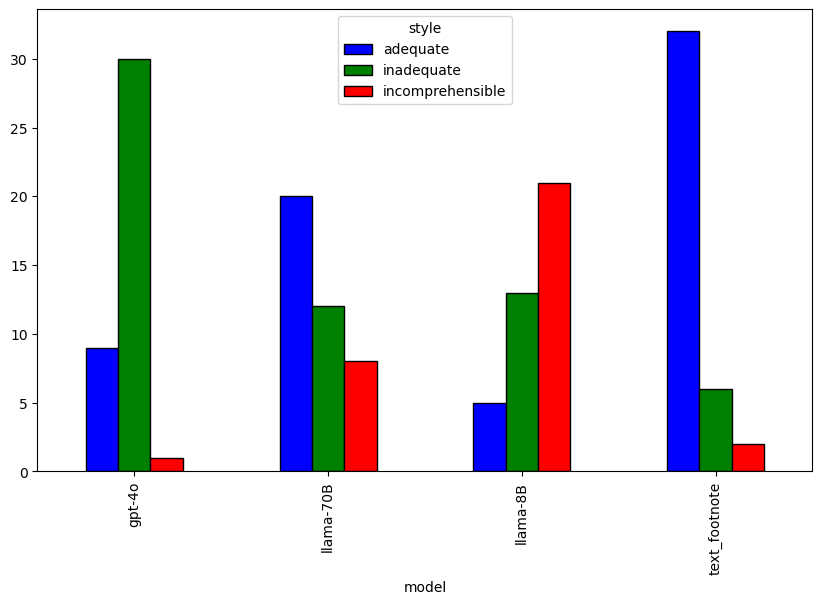

In [12]:
import matplotlib.pyplot as plt
# Prepare data for the plot
counts = luca_df.groupby(['model', 'style']).size().unstack(fill_value=0)

# Plot grouped bar chart
counts.plot(kind='bar', figsize=(10, 6), color=['blue', 'green', 'red'], edgecolor='black')

<Axes: xlabel='model'>

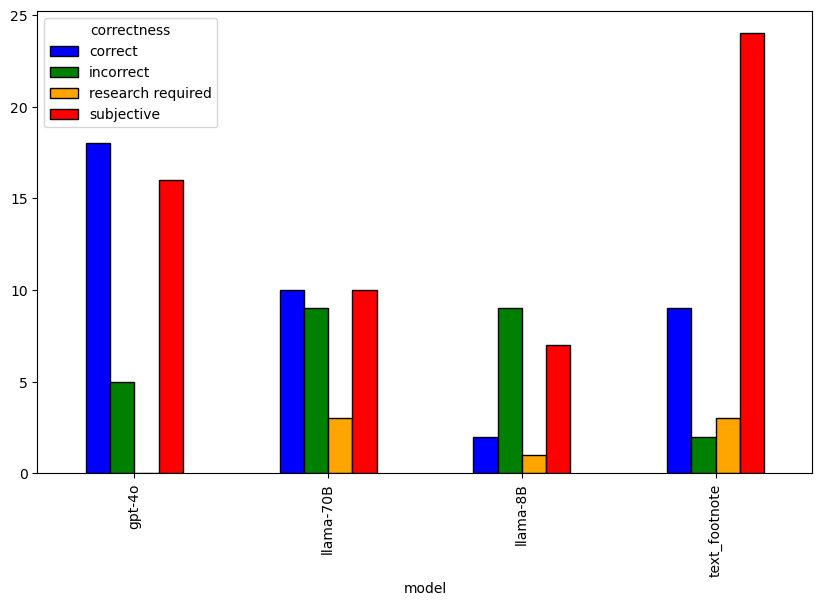

In [10]:
counts = luca_df.groupby(['model', 'correctness']).size().unstack(fill_value=0)

# Plot grouped bar chart
counts.plot(kind='bar', figsize=(10, 6), color=['blue', 'green', "orange", 'red'], edgecolor='black')

<Axes: xlabel='model'>

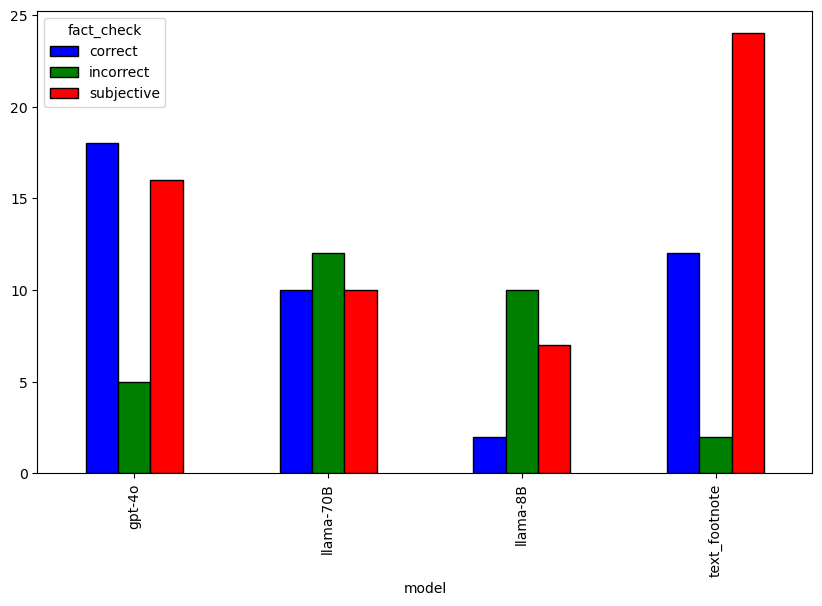

In [7]:
counts = luca_df.groupby(['model', 'fact_check']).size().unstack(fill_value=0)

# Plot grouped bar chart
counts.plot(kind='bar', figsize=(10, 6), color=['blue', 'green', 'red', "orange"], edgecolor='black')

<Axes: xlabel='model'>

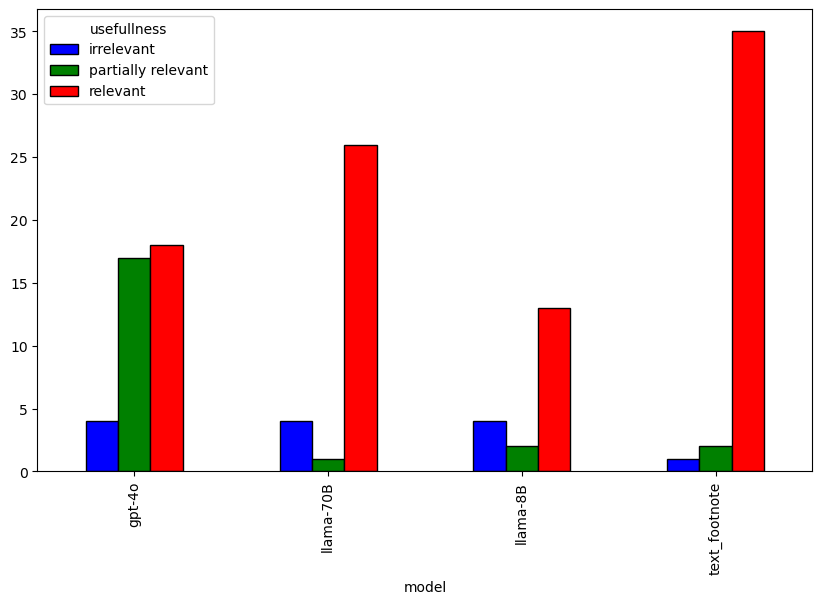

In [8]:
counts = luca_df.groupby(['model', 'usefullness']).size().unstack(fill_value=0)

# Plot grouped bar chart
counts.plot(kind='bar', figsize=(10, 6), color=['blue', 'green', 'red'], edgecolor='black')